# MODS Observing Planning sandbox

Based on the Gaia Archive tutorial (located at the Gaia Archive, http://archives.esac.esa.int/gaia -> Help -> Tutorials -> Cluster analysis ) and adapted it to python.
The tutorial uses the Gaia TAP+ (astroquery.gaia) module, http://astroquery.readthedocs.io/en/latest/gaia/gaia.html#module-astroquery.gaia 


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

import math
import time

# astropy for coordinates and units

from astropy.coordinates import SkyCoord, Distance
from astropy.time import Time

from astropy import units as u
from astropy.units import Quantity

# astroquery for Gaia and TAP+

from astroquery.gaia import Gaia
from astroquery.utils.tap import TapPlus

# Suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore')

# Load gaia tables - only needs to be done once per run, good for multiple queries

tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


## Functions

Some functions we need
 * `pointInBox()` - test whether point `(x,y)` is inside a box with `(llx,lly,width,height)`
 * `parAngle()` - compute parallax angle for site latitide `lat` and target declination `dec` at hour angle `ha`
 * `airMass()` - compute airmass for site latitude `lat` and target declination `dec` at hour angle `ha`
 
Site latitude and declination are given in decimal degrees, hour angle in decimal hours.

In [9]:
def pointInBox(point,box):
    '''
    point = (x,y) coordinates of the point of interest
    box = (llx,lly,width,height) of the box
    
    returns True if (x,y) in box or False
    '''
    x1, y1, w, h = box
    x2, y2 = x1+w, y1+h
    x, y = point
    if (x1 < x and x < x2):
        if (y1 < y and y < y2):
            return True
    return False

def parAngle(lat,dec,ha):
    '''
    lat = latitude in decimal degrees
    dec = declination in decimal degrees
    ha = hour angle in hours
    
    returns parallactic angle in degrees
    '''
    latRad = math.radians(lat)
    decRad = math.radians(dec)
    haRad  = math.radians(15.0*ha)

    top = math.sin(haRad)
    bot = math.tan(latRad)*math.cos(decRad) - math.sin(decRad)*math.cos(haRad)
    parAng = math.degrees(math.atan2(top,bot))
    if parAng < -90:
        parAng = -(parAng + 180)
    if parAng > 90:
        parAng = 180 - parAng

    return parAng

def airMass(lat,dec,ha):
    '''
    lat = latitude in decimal degrees
    dec = declination in decimal degrees
    ha = hour angle in hours
    
    returns airMass (dimensionless)
    '''
    latRad = math.radians(lat)
    decRad = math.radians(dec)
    haRad  = math.radians(15.0*ha)

    cosZD = math.sin(latRad)*math.sin(decRad) + math.cos(latRad)*math.cos(decRad)*math.cos(haRad)
    if (cosZD > 0.0):
        am = 1.0/cosZD
        if am > 99.0:
            am = 99.99;
    return am

def rotXY(x,y,rotAng):
    '''
    rotate (x,y) coordinates by angle rotAng in degrees
    '''
    if rotAng==0.0 or rotAng==-0.0:
        return x, y
    else:
        sinPA = math.sin(math.radians(rotAng))
        cosPA = math.cos(math.radians(rotAng))
        xr = x*cosPA - y*sinPA
        yr = x*sinPA + y*cosPA
        return xr, yr


## MODS, Gaia DR3 search, and plot setup

Basic parameters of the LBT and MODS instrument
 * f/15 direct gregorian image scale
 * faint and bright limits for AGw unit guide/wfs stars
 * center and dimensions of the MODS science field
 * center and dimensions of the MODS AGw unit patrol field
 * radii of the MODS science+guider swept field for rotation about field center
 * segmented long-slit mask centers and dimensions
 
Basic parameters for the Gaia DR3 database search
 * limiting G magnitude
 * others?

matplotlib setup parameters

In [10]:
# MODS and LBT information

lbtScale = 0.600 # LBT focal plane scale in mm/arcsec
#minRMag = 16.5   # Typical guide star R magnitude limits for the MODS AGw unit
minRMag = 21.5   # Typical guide star R magnitude limits for the MODS AGw unit
#maxRMag = 12.0
maxRMag = 8.9

# MODS science field at PA 0, center and width/heightin arcseconds

(sciX,sciY) = (0,0)
(sciW,sciH) = (360,360)

sciBox = (sciX-0.5*sciW,sciY-0.5*sciH,sciW,sciH) # llx, lly, width, height

# MODS guide patrol field at PA=0, center and width/height in arcsec

(gpfX,gpfY) = (0,-150.0)   
(gpfW,gpfH) = (290,300)   

gpfBox = (gpfX-0.5*gpfW,gpfY-0.5*gpfH,gpfW,gpfH) # llx, lly, width, height

# 180-degree flipped guide patrol field

gprBox = (gpfX-0.5*gpfW,gpfY+0.5*gpfH,gpfW,gpfH)

# radius of the MODS swept field of view

xgpfl = (sciX-0.5*gpfW)
xgpfr = (sciX+0.5*gpfW)
ygpfb = (sciY-gpfY+0.5*gpfH)

drll = math.sqrt(xgpfl*xgpfl + ygpfb*ygpfb)
drlr = math.sqrt(xgpfr*xgpfr + ygpfb*ygpfb)

msRad = np.min([drll,drlr])

# closest a guide star candidate can come to the target in arcsec

rsMin = 60.0 # arcsec
rsMin = 0.0

# Radius of the focal station field-of-view in arcminutes

dgfRad = 6.0   

# Centers of the facility long-slit mask segments in arcsec
  
slitCen = [-126,-63,0,63,126]

# long-slit masks

slitLW = {'LS60x5':(60.0,6.0),
          'LS5x60x0.3':(60.0,0.3),
          'LS5x60x1.6':(60.0,0.6),
          'LS5x60x1.0':(60.0,1.0),
          'LS5x60x1.2':(60.0,1.2),
          'LS5x60x1.5':(60.0,1.5),
          'LS5x60x2.4':(60.0,2.4),
         }

# Gaia magnitude search

minG = 21.0 # faint limit, not many stars though
maxG = 3.0  # bright limit

# default N/E compass size in arcseconds

neCompass = 45.0 # arcsec

# Plot setup 1:1 aspect ratio

aspect = 1.0

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

figFmt = 'png'
dpi = 600
plotWidth = dpi*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 8
lwidth = 0.5
axisPad = 5
wInches = textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'14'})

# Font and line weight defaults for axes

plt.rcParams.update({'axes.linewidth':lwidth})
plt.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']='%d' % (axisPad)
plt.rcParams['ytick.major.pad']='%d' % (axisPad)
plt.rcParams['axes.labelpad'] = '%d' % (axisPad)

## Gaia data query

Perform an asynchronous query centered on the nominal field center with a search
radius of `searchRad` degrees.

Search limits:
 * g mag between `gMax` and `gMin` magnitudes
 * no negative or null parallaxes or proper motions
 
A typical query takes 2-3 seconds with a good internet connection depending on server load (YMMV).

In [16]:
# Target ("object") RA and Dec - or offset field center

objName = 'SDSSJ1347+1630'
objRADec = '13:47:00.860 +16:30:15.37'

objName = 'SDSSJ1407+2814'
objRADec = '14:07:38.083 +28:14:46.14'

objName = 'SDSS J1116+1409'
objRADec = '11:16:13.716 +14:09:05.07'

#objName = 'WISEAJ0743+2606'
#objRADec = '07:43:04.418 +26:05:44.99'

#objID = 'WISEA J0736+2430'
#objRADec = '07:36:42.421 +24:30:22.42'

objName = "Leo P (LP26)"
objRADec = "10:21:45.122 +18:05:16.93"

slitMask = 'LS5x60x1.0'

# SkyCoord object for the target

obj = SkyCoord(objRADec,unit=(u.hourangle, u.deg),frame='icrs')

# Field center and radius in decimal degrees

dRA = obj.ra.value
dDec = obj.dec.value

# search radius for the direct gregorian focii is dgfRad arcminutes, convert to decimal degrees

searchRad = math.sqrt(2)*dgfRad/60.0

# execute the Gaia DR3 query

gQuery=f"""
SELECT *
FROM gaiadr3.gaia_source
WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',{dRA},{dDec},{searchRad}))=1
AND phot_g_mean_mag BETWEEN {maxG} and {minG}
AND parallax IS NOT NULL AND parallax>0
AND pmra IS NOT NULL AND abs(pmra)>0
AND pmdec IS NOT NULL AND abs(pmdec)>0
"""

print('Launching Gaia DR3 query...')

t0 = time.time()
job = Gaia.launch_job_async(gQuery)
j = job.get_results()
dt = time.time() - t0

print(f'Retrieved {len(j)} stars (query took {dt:.1f} seconds)')

#starID = np.array(j['DESIGNATION'])
starID = np.array(j['source_id'])
ra = np.array(j['ra'])
dec = np.array(j['dec'])
parallax = np.array(j['parallax'])
pmra = np.array(j['pmra'])
pmdec = np.array(j['pmdec'])
gMag = np.array(j['phot_g_mean_mag'])
rMag = np.array(j['phot_rp_mean_mag'])
bMag = np.array(j['phot_bp_mean_mag'])
epoch = np.array(j['ref_epoch'])

ms = 1.0 + 0.5*(minG-gMag) # magnitude scaling

gaiaEpoch = epoch[0]

numStars = len(j['source_id'])
print(f'magnitude range: {np.min(gMag):.2f} to {np.max(gMag):.2f}')
print(f'Gaia DR3 Epoch {gaiaEpoch:.2f}')


Launching Gaia DR3 query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 129 stars (query took 2.3 seconds)
magnitude range: 12.96 to 20.86
Gaia DR3 Epoch 2016.00


## Transform to ($\xi,\eta$) coordinates

Transform to "offset" ($\xi,\eta$) coordinates (aka "standard coordinates on the tangent plane") for the observation.  This includes field rotation.  We are rotating the sky into the "fixed" acquisition reference
frame of the MODS spectrograph, rather than rotating and projecting the MODS instrument view onto the sky.

In [17]:
# Instrument position angle (degrees)

posAngle = 0 * u.degree
if posAngle.value > 0:
    backAngle = posAngle.value - 180.0
else:
    backAngle = 180 + posAngle.value
    
pngFile = f'{objName}_pa{int(posAngle.value)}_GaiaDR3.png'

# coordinate object for the nominal field center

modsField = SkyCoord(dRA*u.deg,dDec*u.deg,frame='icrs')

# full coordinate object for the Gaia DR3 stars in the MODS field for obstime=now

stars = SkyCoord(ra=ra*u.deg,
                 dec=dec*u.deg,
                 distance=Distance(parallax=parallax*u.mas,allow_negative=True),
                 pm_ra_cosdec=pmra*u.mas/u.yr,
                 pm_dec=pmdec*u.mas/u.yr,
                 obstime=Time(epoch,format='decimalyear'),
                 frame='icrs')

# Transform field to (xi,eta) coords in arcseconds centered on the MODS field center

skyView = stars.transform_to(modsField.skyoffset_frame(rotation=posAngle))
xi = skyView.lon.to(u.arcsec)
eta = skyView.lat.to(u.arcsec)

# radii of each star relative to the field center in arcseconds in the (xi,eta) plane

rad = np.sqrt(xi*xi + eta*eta) 


## Plot it


623919458025185920 10:21:42.53 +18:04:06.54 rMag=14.91 gMag=16.26 posAng=0.0
623922447322613632 10:21:42.15 +18:05:40.02 rMag=16.97 gMag=18.36 posAng=180.0
623923164581485568 10:21:36.16 +18:07:35.87 rMag=16.29 gMag=16.86 posAng=180.0
623924057934982784 10:21:38.68 +18:09:38.10 rMag=19.72 gMag=20.48 posAng=180.0
623919488089449856 10:21:43.27 +18:05:13.52 rMag=17.71 gMag=18.85 posAng=0.0
623917563943975552 10:21:40.72 +18:01:26.17 rMag=16.75 gMag=17.35 posAng=0.0
623918186714916224 10:21:53.48 +18:00:49.98 rMag=19.50 gMag=19.96 posAng=0.0
623919247571168000 10:21:39.48 +18:02:50.72 rMag=16.58 gMag=17.62 posAng=0.0
623919114427800448 10:21:50.34 +18:02:33.77 rMag=17.51 gMag=18.78 posAng=0.0
623919213211432832 10:21:49.34 +18:03:20.58 rMag=19.50 gMag=19.89 posAng=0.0
623919281930906240 10:21:41.46 +18:02:52.88 rMag=18.06 gMag=19.20 posAng=0.0
623917563947479808 10:21:38.33 +18:01:21.09 rMag=19.16 gMag=20.27 posAng=0.0
623918972693246336 10:21:45.47 +18:01:12.48 rMag=18.43 gMag=19.43 posA

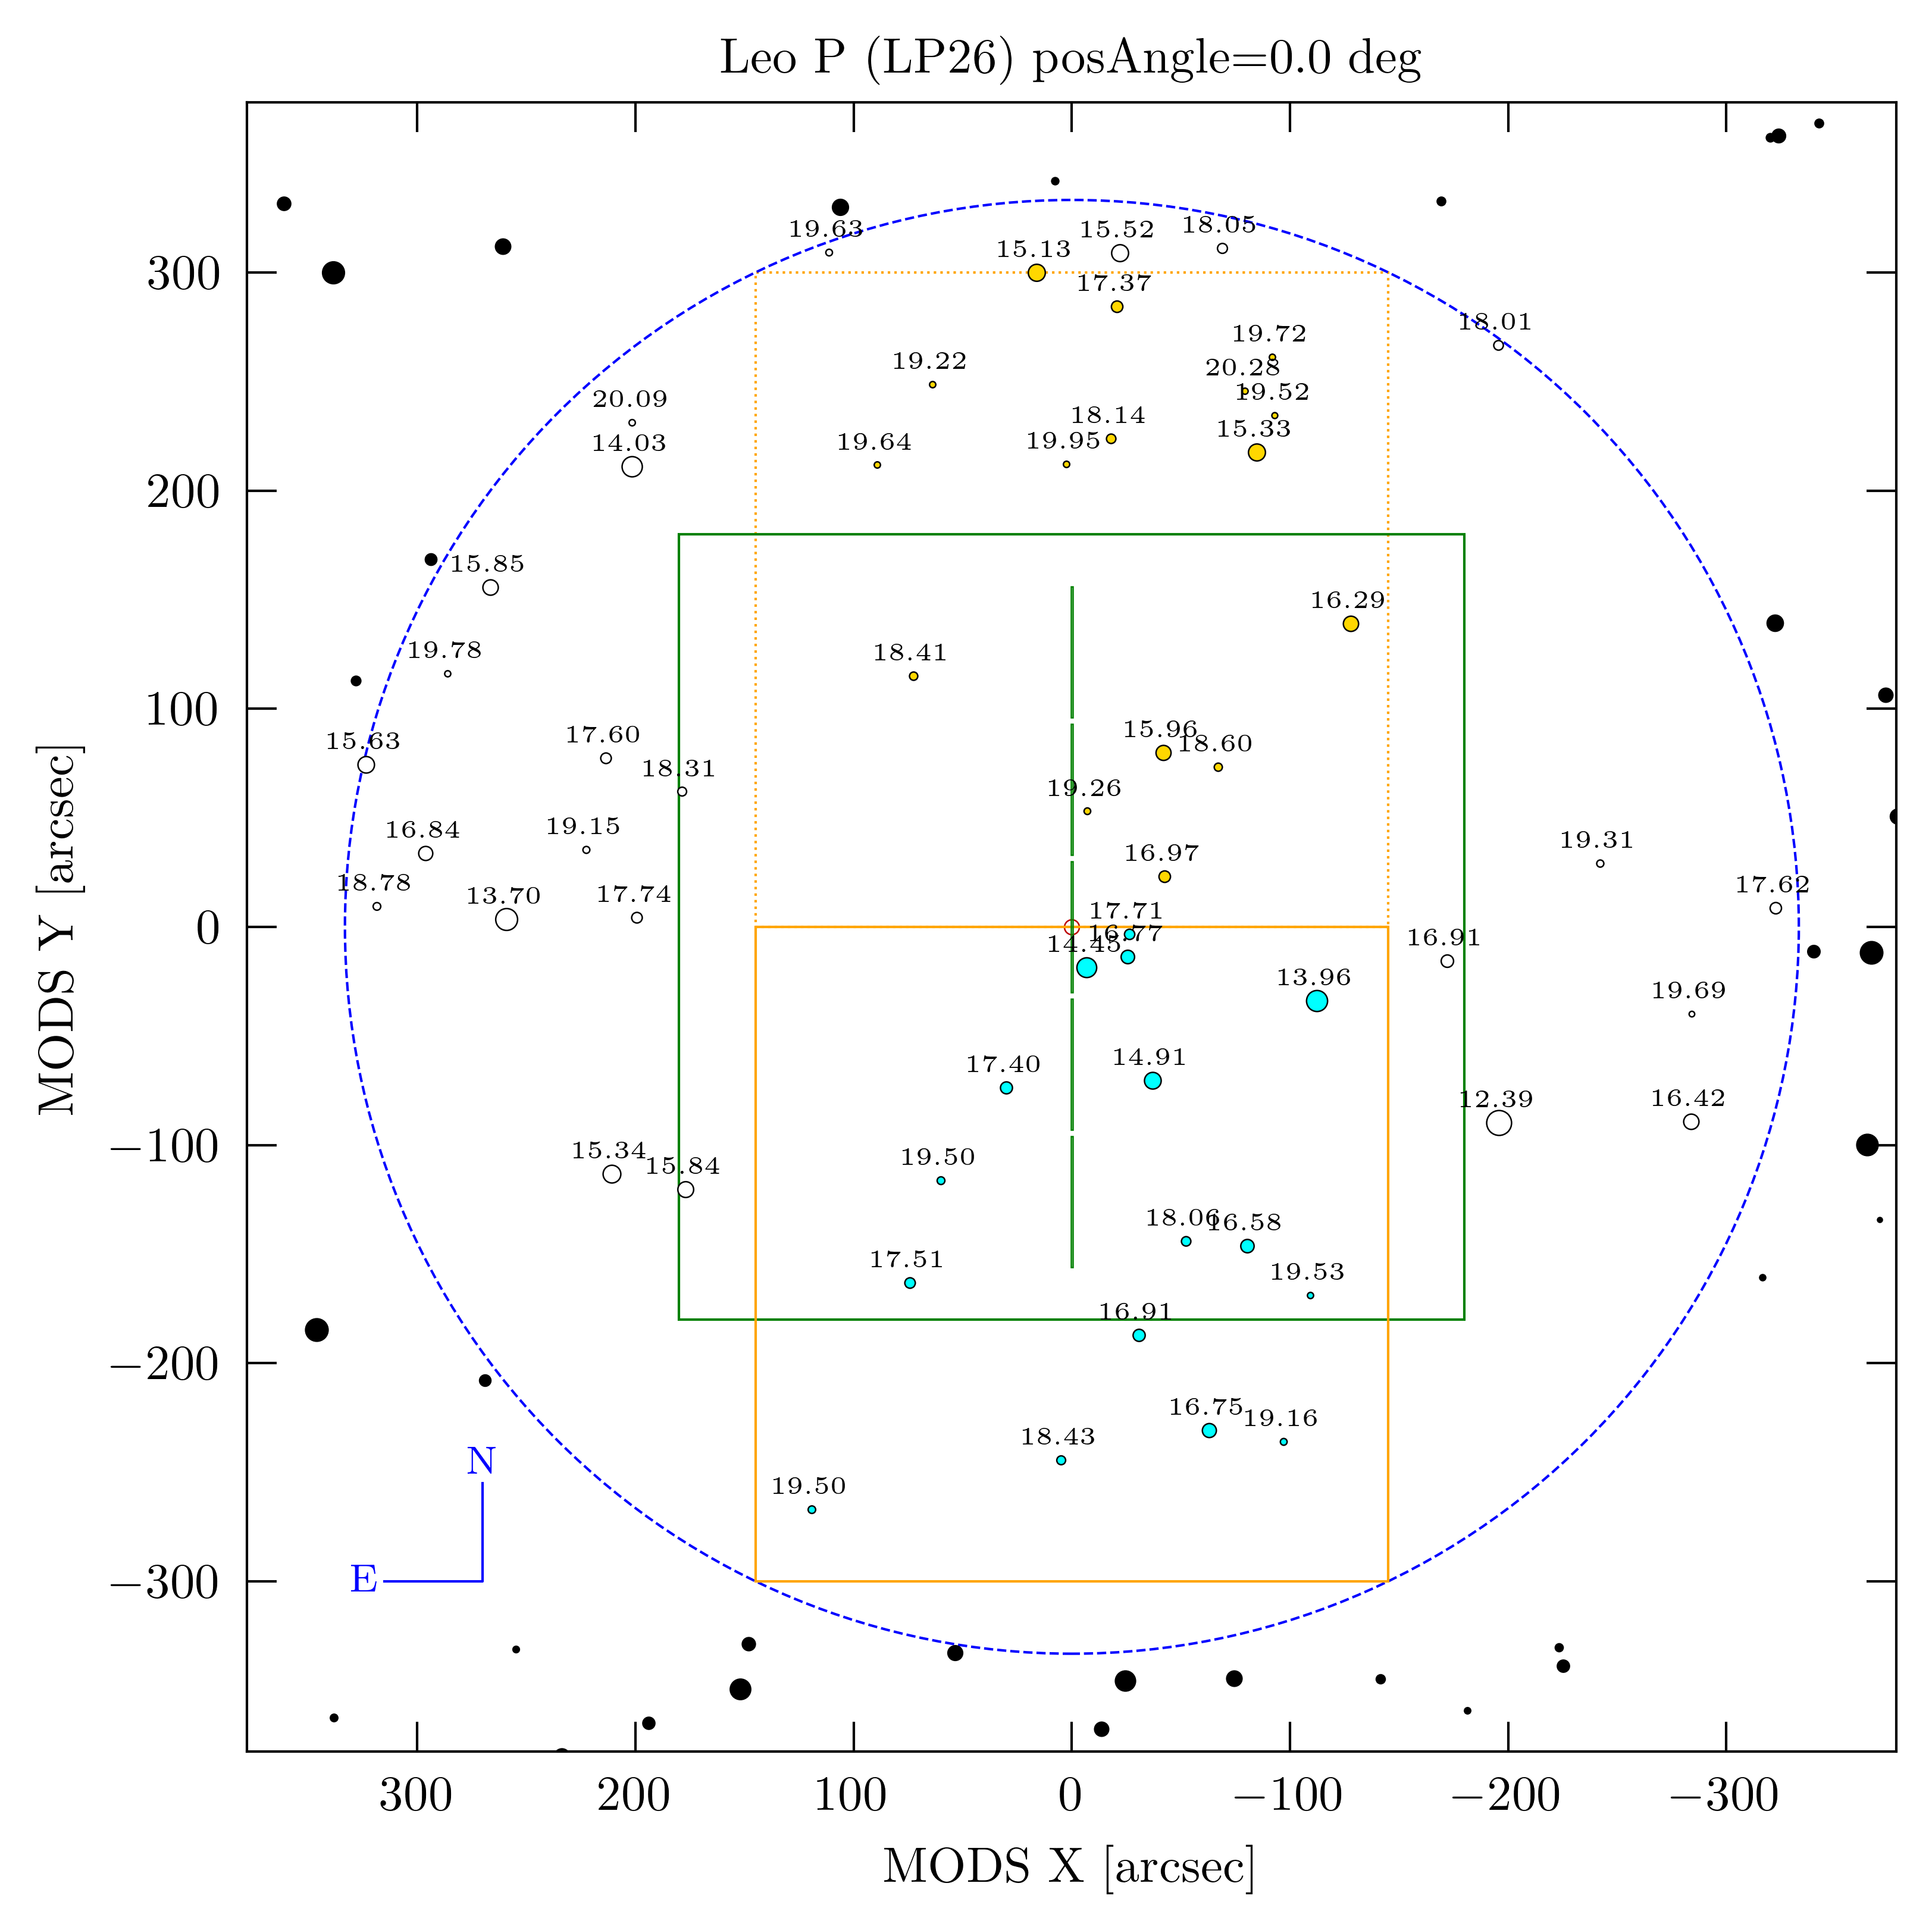

In [27]:
fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

ax.set_aspect('equal')

# plot in arcseconds

halfWidth = 1.05*dgfRad*60.0
ax.set_xlim(halfWidth,-halfWidth)
ax.set_ylim(-halfWidth,halfWidth)

for i in range(len(xi)):
    xs = xi[i].value
    ys = eta[i].value
    rs = rad[i].value
    # label with magnitudes only if in the magnitude limits and the swept area of the guide patrol field
    if (rMag[i] <= minRMag and rMag[i] >= maxRMag) and (rs <= msRad and rs >= rsMin):
        if pointInBox((xs,ys),gpfBox):
            sfc = 'cyan'
            raStr = stars[i].ra.to_string(unit=u.hour,sep=':',precision=2,pad=True)
            decStr = stars[i].dec.to_string(unit=u.degree,sep=':',precision=2,pad=True,alwayssign=True)
            print(f'{starID[i]} {raStr} {decStr} rMag={rMag[i]:.2f} gMag={gMag[i]:.2f} posAng={posAngle.value:.1f}')
        elif pointInBox((xs,ys),gprBox):
            sfc = 'gold'
            raStr = stars[i].ra.to_string(unit=u.hour,sep=':',precision=2,pad=True)
            decStr = stars[i].dec.to_string(unit=u.degree,sep=':',precision=2,pad=True,alwayssign=True)
            print(f'{starID[i]} {raStr} {decStr} rMag={rMag[i]:.2f} gMag={gMag[i]:.2f} posAng={backAngle:.1f}')
        else:
            sfc = 'white'
        ax.plot(xs,ys,mfc=sfc,mec='black',mew=0.3,alpha=1,marker='o',ms=ms[i],zorder=10)
        ax.text(xs,ys+5,f'{rMag[i]:.2f}',va='bottom',ha='center',fontsize=5,zorder=10)
    else:
        ax.plot(xs,ys,mfc='black',mec='black',mew=0.2,alpha=1,marker='o',ms=ms[i],zorder=10)
        
# target aim point

ax.plot(0,0,'o',mew=0.3,mfc='none',mec='#bb0000',ms=3,zorder=5)

# MODS science field

sciField = plt.Rectangle((sciX-0.5*sciW,sciY-0.5*sciH),sciW,sciH,ec='green',fc=None,fill=False,
                         lw=0.5,ls='-',zorder=8)

gpField = plt.Rectangle((gpfBox[0],gpfBox[1]),gpfW,gpfH,ec='orange',fc=None,fill=False,
                         lw=0.5,ls='-',zorder=8)

gfField = plt.Rectangle((gprBox[0],gprBox[1]),gpfW,gpfH,ec='orange',fc=None,fill=False,
                         lw=0.5,ls=':',zorder=7)

gpSweep = plt.Circle((sciX,sciY),msRad,ec='blue',fc=None,lw=0.5,ls='--',fill=False,zorder=7)

ax.add_patch(sciField)
ax.add_patch(gpField)
ax.add_patch(gfField) # flipped gpf
ax.add_patch(gpSweep)


if slitMask is not None:
    slitH, slitW = slitLW[slitMask]
    xCen = -0.5*slitW
    for yCen in slitCen:
        slitSegment = plt.Rectangle((xCen,yCen-0.5*slitH),slitW,slitH,ec='green',fc=None,fill=False,
                                    lw=0.3,ls='-',zorder=8)
        ax.add_patch(slitSegment)

# Label

ax.set_xlabel('MODS X [arcsec]',fontsize=axisFontSize)
ax.set_ylabel('MODS Y [arcsec]',fontsize=axisFontSize)
ax.set_title(f'{objName} posAngle={posAngle.value:.1f} deg',fontsize=axisFontSize)

# Add a N-E celestial compass

xE,yE = rotXY(neCompass,0,posAngle.value)
xN,yN = rotXY(0,neCompass,posAngle.value)
x0,y0 = (270,-300)
ax.plot([x0+xE,x0,x0+xN],[y0+yE,y0,y0+yN],'-',lw=0.5,color='blue')
xlabE,ylabE = rotXY(1.2*neCompass,0,posAngle.value)
ax.text(x0+xlabE,y0+ylabE,'E',color='blue',fontsize=8,va='center',ha='center') # ,rotation=posAngle.value)
xlabN,ylabN = rotXY(0,1.2*neCompass,posAngle.value)
ax.text(x0+xlabN,y0+ylabN,'N',color='blue',fontsize=8,va='center',ha='center') # ,rotation=posAngle.value)

# Plot and save

plt.show()
#fig.savefig(pngFile,bbox_inches='tight',facecolor='white')

## Find candidate blind offset reference stars

For each Gaia star found, compute the angular separation in arcseconds on the sky.  Then sort by increasing separation
distance and list the stars from nearest to farthest from the target, giving the magnitude

In [26]:
magFaint = 18.0
radMax = 150.0  # arcsec

sepRad = []
for star in stars:
    sep = star.separation(obj)
    sepRad.append(sep.arcsecond)

print(f"{objID} candidate blind offset stars:")
print("\nStarID                  RA (J2000)    Dec (J2000)   R     sep      dRA      dDec")

for i in np.argsort(sepRad):
    if (rMag[i] <= magFaint and sepRad[i] <= radMax):
        refStar = SkyCoord(stars[i].ra,stars[i].dec,unit=(u.deg,u.deg),frame='icrs')
        dra, ddec = refStar.spherical_offsets_to(obj)
        raStr = stars[i].ra.to_string(unit=u.hour,sep=':',precision=3,pad=True)
        decStr = stars[i].dec.to_string(unit=u.degree,sep=':',precision=2,pad=True,alwayssign=True)
        raOff = dra.to(u.arcsec).value
        decOff = ddec.to(u.arcsec).value
        print(f'Gaia {starID[i]} {raStr} {decStr} {rMag[i]:5.2f} {sepRad[i]:6.2f}\" {raOff:8.3f} {decOff:8.3f}')

print("\nOffset is from the reference star to the target in arcseconds")

WISEA J0736+2430 candidate blind offset stars:

StarID                  RA (J2000)    Dec (J2000)   R     sep      dRA      dDec
Gaia 623919492384922624 10:21:44.645 +18:04:58.23 14.45  19.90"    6.804   18.705
Gaia 623919488089449856 10:21:43.274 +18:05:13.52 17.71  26.57"   26.350    3.414
Gaia 623919492384922880 10:21:43.325 +18:05:03.15 16.77  29.09"   25.616   13.780
Gaia 623922447322613632 10:21:42.148 +18:05:40.02 16.97  48.29"   42.407  -23.093
Gaia 623919423665445504 10:21:47.232 +18:04:03.38 17.40  79.47"  -30.087   73.550
Gaia 623919458025185920 10:21:42.531 +18:04:06.54 14.91  79.49"   36.940   70.387
Gaia 623922893999020416 10:21:42.181 +18:06:36.68 15.96  90.11"   41.941  -79.751
Gaia 623922305587741056 10:21:37.248 +18:04:43.06 13.96 117.28"  112.277   33.880

Offset is from the reference star to the target in arcseconds


## Further processing?

In [23]:
for i in range(len(stars)):
    raStr = stars[i].ra.to_string(unit=u.hour,sep=':',precision=3,pad=True)
    decStr = stars[i].dec.to_string(unit=u.degree,sep=':',precision=3,pad=True,alwayssign=True)
    if rMag[i]>14 and rMag[i]<15:
        print(f'{starID[i]} {raStr} {decStr} rMag={rMag[i]:.2f} gMag={gMag[i]:.2f}')

623919458025185920 10:21:42.531 +18:04:06.544 rMag=14.91 gMag=16.26
623917911836958080 10:21:55.787 +17:59:27.640 rMag=14.08 gMag=14.57
623943544201776384 10:21:59.272 +18:08:47.929 rMag=14.03 gMag=14.85
623919492384922624 10:21:44.645 +18:04:58.225 rMag=14.45 gMag=15.03
623921863206876416 10:21:17.401 +18:05:19.688 rMag=14.72 gMag=15.96
623916709246118272 10:21:43.403 +17:59:31.256 rMag=14.23 gMag=14.71
